In [1]:
"""
Created on Mon 20 Nov 2017.

Walk through the paper:
Personalized Risk Scoring for Critical Care Prognosis using Mixtures of Gaussian Processes

Preparation for the Reading Group 27 Nov 2017

@author: mpimentel
"""

import numpy as np
import pandas as pd
from time import time
import sys 

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

from IPython.display import Image

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# machine learning libraries
import gpflow

# metrics
#from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%matplotlib inline

sns.set_style("dark")

# Reading Group
## Personalized Risk Scoring for Critical Care Prognosis using Mixtures of Gaussian Processes

Marco AF Pimentel

27 November 2017

<sub> http://gitlab.com/mpimentel/readinggroups </sub>

<img src="http://www.supercoloring.com/sites/default/files/silhouettes/2015/05/oxford-skyline-black-silhouette.svg" width=5012>

## Authors

<center>
<img src="http://freelogo2016cdn.b-cdn.net/wp-content/uploads/2016/12/UCLA_Logo_University_of_California_Los_Angeles.png" width=128 align="middle">
</center>

- Ahmed M. Alaa, Machine Learning 
- Yoon Jinsung, Machine Learning
- Scott Hu, MD
- Michaela van der Schaar

## Introduction

### An overview of the paper

<center>
<img src="img/WC_RG_27112017.png" width=1000 align="middle">
<sub> (Created using www.worldclouds.com) <sub>
</center>

### The problem

- More than 200,000 hospitalized patients have cardiac arrests each year in the US

- 75% of those die

- Many of those cardiac arrests could be prevented, as unanticipated events **are often preceded** by disorder in a patient's physiological parameters

- Current risk scores provide only modest contributions to clinical outcomes
    - use a small subset of the available EHR data
    - "one-size-fits-all" approach (not personalized)
    - modelling approach for dealing with different types of the data

### The goal

- To develop a risk scoring algorithm that provides personalized assessments for the acuity of critical care patients in a hospital ward

## Challenges

## Related Works

Risk scoring systems (these are typically _used and built for different purposes_):

- **Expert-based** scoring systems (Early warning score, EWS)

- **Regression-based** methods (e.g., APACHE and other recent logistic regression-based approaches)

- Approaches that use **Gaussian process** regression

- Methods based on **survival analysis** (Cox regression-based model)

- A few _personalized_ risk prognosis models

## The physiological model

**Physiological information**
- D sparse variables acquired over time with the following properties:

    1) variables can be measured at different times

    2) one variable can be measured more often than the other
    
$$X(t) = [X_1(t),X_2(t),...,X_D(t)]^T$$

Specifically, for one patient we have the following physiological information:

$$[X_i(t_{ij})]_{i=1,j=1}^{D,M_i}, [x_{ij}, t_{ij}]_{ij}$$

where $i = 1,...,D$ variables, and $j = 1,...,M_i$ samples for variable $i$.

**Admission information**
- patient's static information (age, gender, admission diagnoses, etc)
$$Y=y$$

**Clinical status**
- what we are trying to predict:

$$ V = \begin{cases} 
0 &\text{clinically stable} \\
1 &\text{clinically deteriorating}
\end{cases}$$

- at a certain time $t$, a patient's risk score $R(t)$ is estimated:

$$ \bar{R}(t) = \mathbb{P}(V=1 | y, [x_{ij}, t_{ij} \leq t ]_{ij}) $$


### The model

<center>
<img src="img/graphical_model_before.png" height=800 align="middle">
</center>

### The model

<center>
<img src="img/graphical_model.png" height=1000 align="middle">
</center>

#### Modelling the physiological signals

- D phsyiological streams modelled as a multitask Gaussian process (GP)

- Hyperparameters depend on the patient's latent clinical status $V$

- Stable and deteriorating patients modelled differently

    1) Stable patients do not exhibit changes in their clinical status => stationary model
    
    2) Deteriorating patients pass through phases of clinical acuity => non-stationary model

# Let's divert from the paper for "9 minutes"
## (simply to address a couple of notions)

##### Challenges of GP inference (nowadays)

**Scalling**
- GP in general requires $\mathcal{O}(N^3)$ computation.

- e.g., Hensman et al. Gaussian processes for big data. UAI 2013.
 
**Non-conjugate likelihoods**
- Inference is only analytically tractable for the Gaussian likelihood.

- Use of integrated approximation.

A Gaussian process can be described as a ***distribution over functions***, which is fully specified by a mean *function* and a covariance *function*:

$$p(x) \sim \mathcal{GP}(m(t), k(t,t^{\prime}))$$

For example, one specification of a GP might be as follows:

$$\begin{aligned}
m(t) &=\theta_0 \\
k(t,t^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(t-t^{\prime})^2\right)
\end{aligned}$$

here, the covariance function is a **squared exponential**, where typically $\theta_1 = \omega_0^2$ and $\theta_2 = \frac{1}{\mathcal{l}_0^2}$.

- To make these idea of **distribution over functions** more concrete, let's quickly demonstrate how we obtain realizations from a Gaussian process!

- First, realizations of a **Gaussian distribution**, mean = 0, variance = 1:

    - That's easy: >> *randn*

In [3]:
np.random.seed(42)
x1 = np.random.normal(scale = 1, loc = 0, size = 50000)
x = 0.0

def plot_gauss_sampling(x = 0.0):
    
    sns.kdeplot(x1, shade=True) # simply for reference
    
    # set y to a certain height for visualisation purposes
    if x != 0.0:
        if len(x) < 14:
            plt.scatter(x,0.02*(np.ones(len(x))), color="b")
        else:
            sns.distplot(x, kde=True, hist=False, rug=True, bins=20, color="b")
        
    plt.ylim(0,0.51)

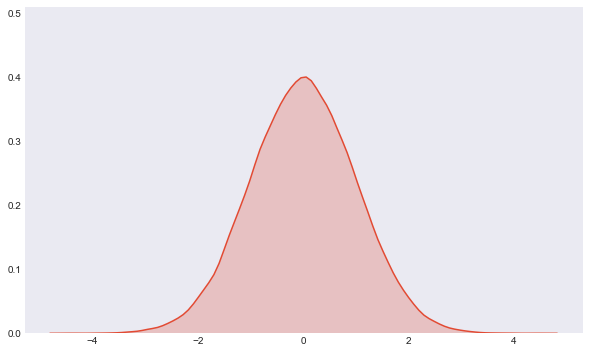

In [4]:
plt.figure(figsize=(10,6))
plot_gauss_sampling()

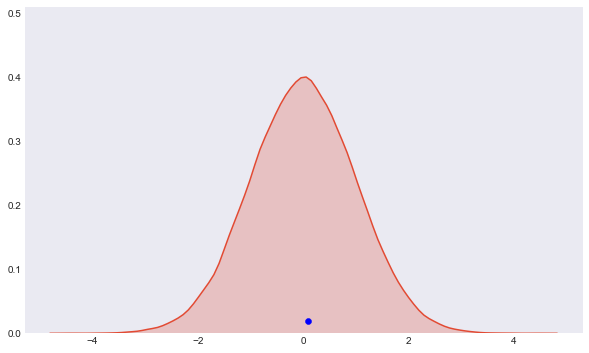

In [5]:
# generate one data point from the Gaussian distribution
x = [np.random.normal(scale = 1, loc = 0, size = 1)]

# display data point
plt.figure(figsize=(10,6))
plot_gauss_sampling(x)

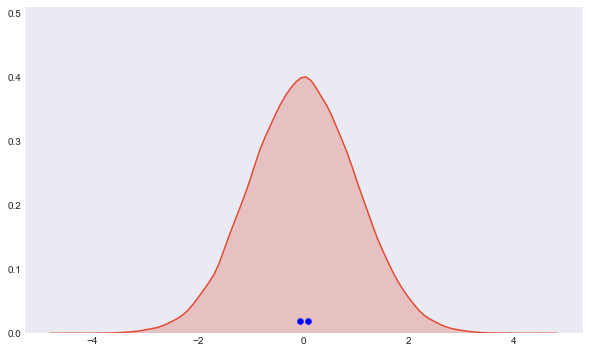

In [6]:
# generate another data point
x.append(np.random.normal(scale = 1, loc = 0, size = 1))

# display data point
plt.figure(figsize=(10,6))
plot_gauss_sampling(x)

- Second, realizations of a **Gaussian process**, with $\theta_0 = 0, \theta_1=1, \theta_2=10$.

$$\begin{aligned}
m(t) &=\theta_0 \\
k(t,t^{\prime}) &= \theta_1\exp\left(-\frac{\theta_2}{2}(t-t^{\prime})^2\right)
\end{aligned}$$

using the conditioning property of mutlivariate Gaussian distributions. Here is that conditional:

$$p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y), 
\Sigma_x-\Sigma_{xy}\Sigma_y^{-1}\Sigma_{xy}^T)$$


In [7]:
# squared exponential covariance function
def exponential_cov(t, t_, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(t, t_)**2)

In [8]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, x, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new

def plot_gp_sampling(x_pred, y_pred, y_errs, x = [], y = []):
    numsteps = 100
    plt.plot(x_pred,y_pred,color='b')
    for i in range(1,numsteps+1):
        top = y_pred + y_errs/numsteps*i*2
        bottom = y_pred - y_errs/numsteps*i*2
        plt.fill_between(x_pred, bottom, top, color='blue', alpha=1.0/numsteps)
    
    if len(x) > 0:
        plt.plot(x, y, "ro")
        
    plt.xlim(-3, 3)
    plt.ylim(-5, 5)

# define x range
xpts = np.arange(-3, 3, step=0.01)
x_pred = np.linspace(-3, 3, 1000)
y_pred = np.zeros(len(x_pred))

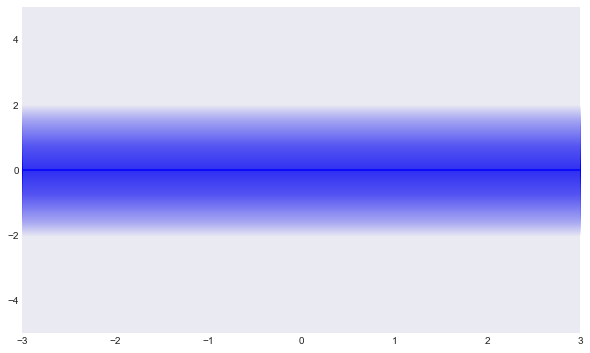

In [9]:
# define parameters of covariance
theta = [1, 10]
# calculate covariance
covar_0 = exponential_cov(0, 0, theta)
y_errs = np.sqrt(covar_0)

plt.figure(figsize=(10,6))
plot_gp_sampling(x_pred, y_pred, y_errs)

In [10]:
# choose an arbitrary data point
x = [1.]
y = [np.random.normal(scale=covar_0)]
y

[0.951790756019536]

We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $[x_0, y_0]$. 

In [11]:
# covariance function in light of new data point
covar_1 = exponential_cov(x, x, theta)

# update prediction
predictions = [predict(i, x, exponential_cov, theta, covar_1, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

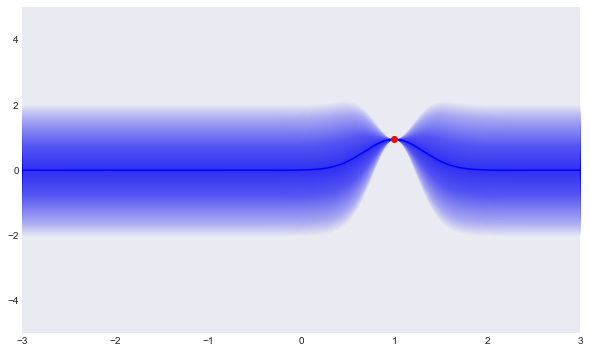

In [12]:
plt.figure(figsize=(10,6))
plot_gp_sampling(x_pred, y_pred, y_errs=sigmas, x=x, y=y)

In [13]:
# conditional Gaussian
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
y2

1.5328316460710738

This point is added to the realization, and can be used to further update the location of the next point.

In [14]:
x.append(-0.7)
y.append(y2)

covar_2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, covar_2, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

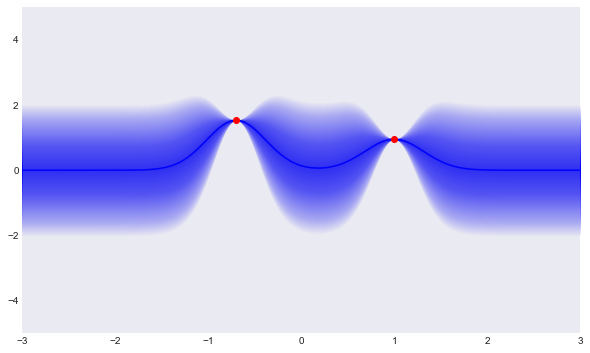

In [15]:
plt.figure(figsize=(10,6))
plot_gp_sampling(x_pred, y_pred, y_errs=sigmas, x=x, y=y)

In [16]:
x_more = [-2.1, -1.5, 0.3, 1.8, 2.5]
mu, s = conditional(x_more, x, y, theta)
y_more = np.random.multivariate_normal(mu, s)

x += x_more
y += y_more.tolist()

covar_new = exponential_cov(x, x, theta)

predictions = [predict(i, x, exponential_cov, theta, covar_new, y) for i in x_pred]
y_pred, sigmas = np.transpose(predictions)

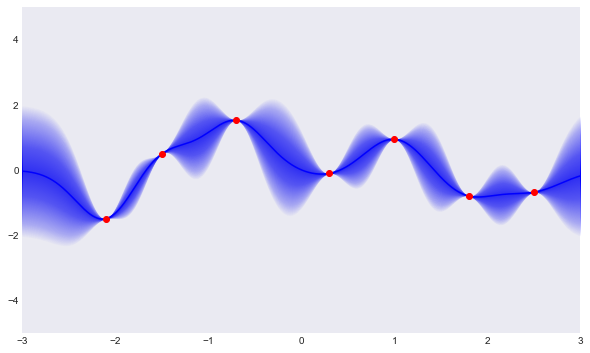

In [17]:
plt.figure(figsize=(10,6))
plot_gp_sampling(x_pred, y_pred, y_errs=sigmas, x=x, y=y)

So as the density of points becomes high, the result will be one realization (function) from the prior GP.

## Single Gaussian process
Given some data, we want to fit a Gaussian process, generate some predictions, which is fulfilled by the *posterior predictive distribution*, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit: 

$$p(y^*|y, x, x^*) = \mathcal{GP}(m^*(x^*), k^*(x^*))$$

where the posterior mean and covariance functions are calculated as (assuming $m(x) = 0$):

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$


Load some sample data.

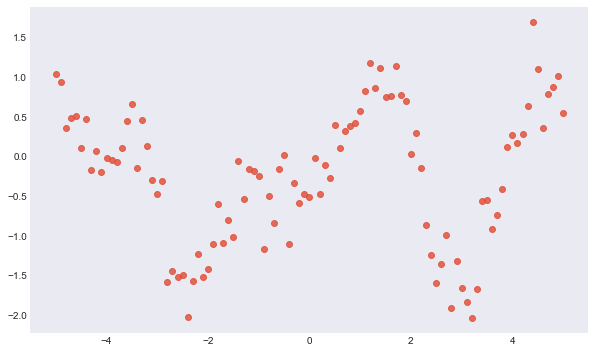

In [18]:
%run utils/get_data.py
plt.figure(figsize=(10,6))
sns.regplot(x, y, fit_reg=False)

In [19]:
Y = y.reshape(-1,1)
X = x.reshape(-1,1)

In [20]:
k = gpflow.kernels.RBF(1, variance=1, lengthscales=1.2)
m = gpflow.mean_functions.Constant(0)
m = gpflow.gpr.GPR(X, Y, kern=k, mean_function=m)
m.likelihood.variance = 0.01

Our Gaussian process prior:

In [21]:
m

In [22]:
m.optimize()

      fun: 51.373842744507122
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.07019825e-05,   2.31209899e-05,   7.71717742e-05,
         1.19863970e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 15
   status: 0
  success: True
        x: array([ 0.01673155,  0.23269853, -2.30043158, -0.0953429 ])

After optimisation:

In [23]:
m

In [24]:
xx = np.linspace(-6, 6).reshape(-1,1)

def plot(m, color='blue'):
    mean, var = m.predict_y(xx)
    
    plt.figure(figsize=(10,6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, color, lw=1)
    
    numsteps = 50
    for i in range(1,numsteps+1):
        top = mean[:,0] + np.sqrt(var[:,0])/numsteps*i*2
        bottom = mean[:,0] - np.sqrt(var[:,0])/numsteps*i*2
        
        plt.fill_between(xx[:,0], bottom, top, color=color, alpha=1.0/numsteps)
        
    plt.xlim(-6, 6)
    plt.ylim(-3, 3)

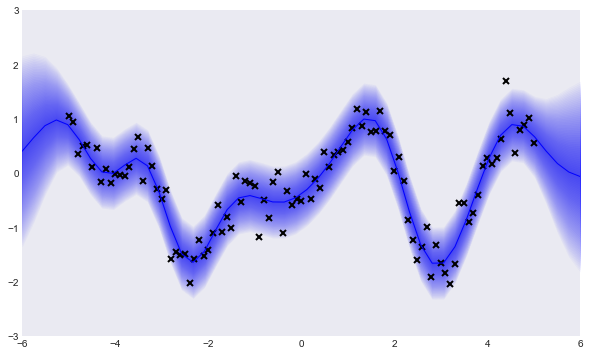

In [25]:
plot(m)

## A multi-task Gaussian process

A multi-task GP is used to model (**potentially**) correlated multiple outputs. MTGP models are specified by adding an extra input dimension:

<center>
<img src="https://www.researchgate.net/profile/Achim_Schweikard/publication/266153494/figure/fig1/AS:295789650825218@1447533156634/Fig-1-Box-diagram-of-multiple-single-task-Gaussian-processes-a-and-a-multi-task.png" height=900 align="middle">
</center>

Let's look at an example (to make things harder, lets create in a gap in one of the outputs).

In [26]:
# create sample data
X1 = X.copy()
Y1 = Y.copy()
X2 = X.copy()
y2 = -1*y + 6.1 + np.random.normal(size=len(X))/5
Y2 = y2.reshape(-1,1)
X3 = X2[66:100]
Y3 = Y2[66:100]
X2 = X2[0:65]
Y2 = Y2[0:65]

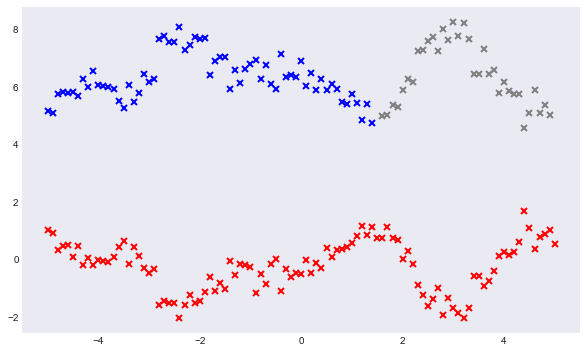

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(X1, Y1, 'rx', mew=2)
plt.plot(X2, Y2, 'bx', mew=2)
plt.plot(X3, Y3, 'x', color='grey' ,mew=2)

To build a GP with correlated multiple outputs, we'll use a kernel of the form

$$cov(f_i(t), f_j(t')) = k_1(t,t') \times B(i,j)$$

The covariance of the i'th function at x and the j'th function at y is a kernel applied at x and y, times the i, j'th entry of a positive definite matrix B. This is known as the **intrinsic model of coregionalization**.
To make sure that B is positive-definite, we parameterize is as

$$B = W W^\top + \textrm{diag}(\kappa)$$

In [28]:
# build a variational model
lik = gpflow.likelihoods.SwitchedLikelihood([gpflow.likelihoods.StudentT(), gpflow.likelihoods.StudentT()])
k1 = gpflow.kernels.RBF(1)
coreg = gpflow.kernels.Coregion(1, output_dim=2, rank=1, active_dims=[1])
kern = k1 * coreg
X_augmented = np.vstack((np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2)))))
Y22 = Y2 - np.mean(Y2)
Y_augmented = np.vstack((np.hstack((Y1, np.zeros_like(X1))), np.hstack((Y22, np.ones_like(X2)))))

m = gpflow.svgp.SVGP(X_augmented, Y_augmented,
                     kern=kern, likelihood=lik, num_latent=1,
                     Z=X_augmented[::3].copy())

m.optimize(max_iters=500)

/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python2.7/site-packages/gpflow/model.py:317: VisibleDeprecationWarning: Use `maxiter` instead of deprecated `max_iters`.
  warnings.warn("Use `maxiter` instead of deprecated `max_iters`.", np.VisibleDeprecationWarning)


      fun: 97.084671228229396
 hess_inv: <1772x1772 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01761569, -0.        ,  0.00443325, ..., -0.00079869,
       -0.00076278, -0.00021572])
  message: 'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 576
      nit: 501
   status: 1
  success: False
        x: array([-4.92848572,  0.        , -4.47071768, ..., -0.04273537,
       -0.02905023,  0.99572936])

In [29]:
m.kern

In [30]:
def plot_mtgp(m):
    plt.figure(figsize=(10, 6))
    # make predictions for first task
    mu, var = m.predict_f(np.hstack((xx, np.zeros_like(xx))))
    # plot mean function and ci
    plt.plot(xx, mu, color='red', lw=1)
    numsteps = 50
    for i in range(1,numsteps+1):
        top = mu + np.sqrt(var)/numsteps*i*2
        bottom = mu - np.sqrt(var)/numsteps*i*2
        plt.fill_between(xx[:,0], bottom[:,0], top[:,0], color="red", alpha=1.0/numsteps)
    # plot data points for first task    
    line, = plt.plot(X1, Y1, 'x', color='red', mew=2)
    
    # make predictions for second task
    mu, var = m.predict_f(np.hstack((xx, np.ones_like(xx))))
    # plot mean function and ci
    plt.plot(xx, mu + np.mean(Y2), color='blue', lw=1)
    numsteps = 50
    for i in range(1,numsteps+1):
        top = mu + np.mean(Y2) + np.sqrt(var)/numsteps*i*2
        bottom = mu + np.mean(Y2) - np.sqrt(var)/numsteps*i*2
        plt.fill_between(xx[:,0], bottom[:,0], top[:,0], color='blue', alpha=1.0/numsteps)
    # plot data points for second task    
    line, = plt.plot(X2, Y2, 'x', color='blue', mew=2)
    plt.plot(X3, Y3, 'x', color='grey' ,mew=2)

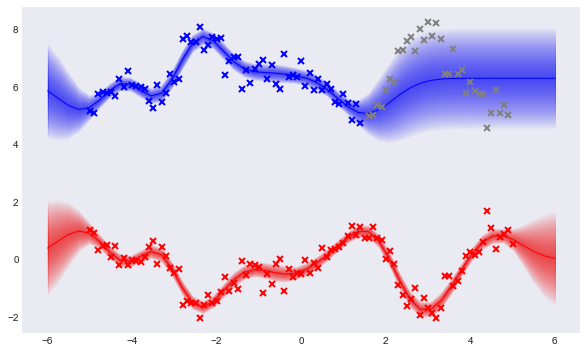

In [31]:
plot_mtgp(m)

In [32]:
m.kern.coregion.W = np.random.randn(2, 1)
m.optimize()
m.kern

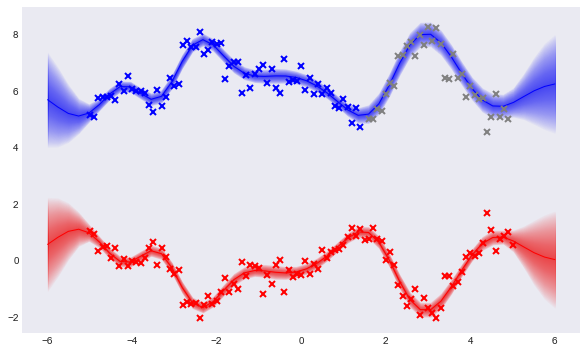

In [33]:
plot_mtgp(m)

In [34]:
# check correlation hyperparameters
np.transpose(m.kern.coregion.W.value)*m.kern.coregion.W.value + np.diag(m.kern.coregion.kappa.value)

array([[  9.86539674,  -9.81128926],
       [ -9.81128926,  10.08833606]])

## Back to the paper

### The model

<center>
<img src="img/graphical_model.png" height=1000 align="middle">
</center>

# Conclusions

- Using the hyperparameters of the GP (*Gaussian process experts*) for classification tasks is an interesting one

- *Non-stationarity* "partially" addressed

- Personalisation is achieved with covariates available at admission (demographics, previous diagnoses, etc...) for defining subtypes (or *phenotypes*) 

- *Sequential hypothesis testing* for determining the risk is the way to go

##  Thanks

In [35]:
print('Thanks')

Thanks
